In [1]:
import numpy as np

In [12]:
def make_exp_data(num_sim = 1000, num_user = 1000):
    rng = np.random.default_rng()
    sim_result = np.zeros((num_sim, num_user, 2))
    for sim_i in range(num_sim):
        cluster = rng.multinomial(num_user, [1./3,1./2,1./6])
        for user_i in range(num_user):
            # small
            if user_i<cluster[0]:
                lam = 2
                mu = 0.3
                sig = 0.05
            # medium
            elif user_i<cluster[0]+cluster[1]:
                lam = 5
                mu = 0.5
                sig = 0.1
            #high
            else:
                lam = 30
                mu = 0.8
                sig = 0.05
            N_i = rng.poisson(lam=lam)
            mu_i = rng.normal(loc=mu, scale=sig)
            try:
                Y_i = rng.binomial(N_i, mu_i)
            except:
                Y_i = N_i
            sim_result[sim_i, user_i, :] = [N_i, Y_i]
    return sim_result
sim_result_A = make_exp_data()
sim_result_B = make_exp_data()

In [13]:
def delta_var(sim_result):
    mu = sim_result.mean(axis=1)
    cov = np.asarray([[np.cov(sim_result[i,:,0], sim_result[i,:,1], ddof=1)[0,0], np.cov(sim_result[i,:,0],sim_result[i,:,1], ddof=1)[1,1], np.cov(sim_result[i,:,0],sim_result[i,:,1], ddof=1)[0,1]] for i in range(sim_result.shape[1])])
    var = (1./(sim_result.shape[1]*np.square(mu[:,0]))*
        (cov[:,1]-
         2*mu[:,1]/mu[:,0]*cov[:,2] + 
         np.square(mu[:,1])/np.square(mu[:,0])*cov[:,0])
          )
    return var

def calc_ctr(sim_result):
    return sim_result.mean(axis=1)[:,1]/sim_result.mean(axis=1)[:,0]

In [14]:
from scipy import stats
def delta_p(sim_result_A, sim_result_B):
    p_list = []
    ctr_array_A = calc_ctr(sim_result_A)
    delta_var_array_A = delta_var(sim_result_A)

    ctr_array_B = calc_ctr(sim_result_B)
    delta_var_array_B = delta_var(sim_result_B)
    for i in range(sim_result_A.shape[0]):
        p_value = stats.ttest_ind_from_stats(mean1=ctr_array_A[i],
                                             std1=np.sqrt(delta_var_array_A[i]*sim_result_A.shape[1]),
                                             nobs1=sim_result_A.shape[1],
                                             mean2=ctr_array_B[i],
                                             std2=np.sqrt(delta_var_array_B[i]*sim_result_B.shape[1]),
                                             nobs2=sim_result_B.shape[1], 
                                             equal_var=False)[1]
        p_list.append(p_value)
    return p_list

Text(0.5, 1.0, 'delta method')

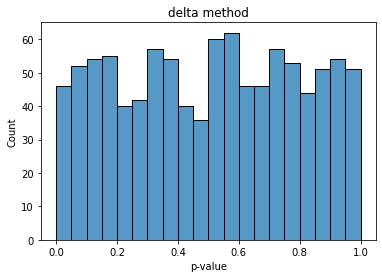

In [21]:
import seaborn as sns
p = sns.histplot(data=delta_p(sim_result_A, sim_result_B), bins=20)
p.set_xlabel("p-value")
p.set_title("delta method")

Text(0.5, 1.0, 'naive method')

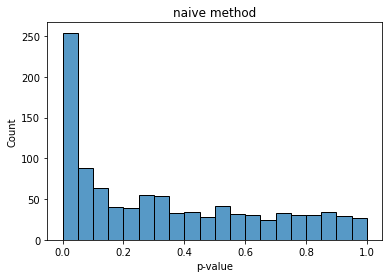

In [22]:
import seaborn as sns
def naive_p_value(sim_result_A, sim_result_B):
    p_list = []
    ctr_array_A = calc_ctr(sim_result_A)
    delta_var_array_A = delta_var(sim_result_A)
    
    ctr_array_B = calc_ctr(sim_result_B)
    delta_var_array_B = delta_var(sim_result_B)
    num_sample_A = sim_result_A.sum(axis=1)[:,0]
    num_sample_B = sim_result_B.sum(axis=1)[:,0]
    for i in range(sim_result_A.shape[0]):
        p_value = stats.ttest_ind_from_stats(mean1=ctr_array_A[i],
                                             std1=np.sqrt(ctr_array_A[i]*(1.-ctr_array_A[i])),
                                             nobs1=num_sample_A[i],
                                             mean2=ctr_array_B[i],
                                             std2=np.sqrt(ctr_array_B[i]*(1.-ctr_array_B[i])),
                                             nobs2=num_sample_B[i], 
                                             equal_var=False)[1]
        p_list.append(p_value)
    return p_list
p = sns.histplot(data=naive_p_value(sim_result_A, sim_result_B), bins=20)
p.set_xlabel("p-value")
p.set_title("naive method")

In [23]:
def make_exp_data(num_sim = 1000, num_user = 1000):
    rng = np.random.default_rng()
    sim_result = np.zeros((num_sim, num_user, 2))
    for sim_i in range(num_sim):
        for user_i in range(num_user):
            sim_result[sim_i, user_i, :] = [8, np.random.binomial(8, 0.667, 1)[0]]
    return sim_result

<AxesSubplot:ylabel='Count'>

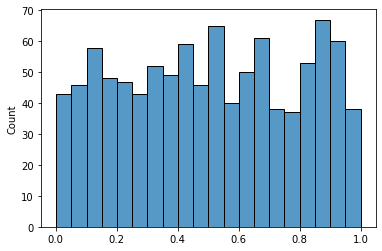

In [18]:
sns.histplot(data=naive_p_value(make_exp_data(), make_exp_data()), bins=20)